![logo cunef](https://www.cunef.edu/wp-content/uploads/2021/06/cunef-logo.svg)
# TRABAJO FINAL ML

## Modelos

**Victor Fernandez-Jimenez & Hugo Pasqual del Pobil**

CUNEF 2021-2022

Machine Learning

### Objetivos:

Aplicar los siguientes modelos de Machine Learning para, dado un accidente, saber si hay al menos un fallecimiento:
* Modelo de regresión lineal simple + Lasso
* Modelo DecisionTreeClassifier
* Modelo GLM
* Modelo RandomForest
* Modelo XGBBoost
* Modelo LightGBM


#### Librerías

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import warnings
import statistics
import random
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, auc

from sklearn.feature_selection import SelectFromModel

import scikitplot as skplt

import xgboost as xgb

import lightgbm as lgb

import pickle

from _Funciones import join_repeated_values, return_not_matches, eval_model, full_evaluation

warnings.filterwarnings("ignore")

# Opciones de viasualización
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#### Importación de los datos

In [2]:
# Importamos los datos
df = pd.read_csv('NCDB_1999_to_2014_1.csv')

# De que tipo son los datos?
print(type(df))

<class 'pandas.core.frame.DataFrame'>


## Transformación de los datos

En primer lugar, se transforma el nombre de las columnas a minúsculas.

In [3]:
df.columns = df.columns.map(lambda x: x[:].lower())

A continucación, vamos a comprobar qué columnas tienen valores únicos duplicados por ser de tipos diferentes (enteros y texto).

In [4]:
for i in df.columns:
    print(i)
    print('Valores únicos: ', df[i].unique())
    print('NAs: ', df[i].isna().sum())
    print('-------------------------------------------------------')

c_year
Valores únicos:  [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014]
NAs:  0
-------------------------------------------------------
c_mnth
Valores únicos:  [1 2 3 4 5 6 7 8 9 10 11 12 '12' 'UU' '01' '02' '11']
NAs:  0
-------------------------------------------------------
c_wday
Valores únicos:  [1 2 3 4 5 6 7 '7' 'U' '1' '2' '3' '4' '5' '6']
NAs:  0
-------------------------------------------------------
c_hour
Valores únicos:  ['20' '08' '17' '15' '14' '01' '11' '13' '19' '16' '09' '02' '18' '12'
 '10' '23' '00' '06' '07' '21' 'UU' '05' '22' '03' '04']
NAs:  0
-------------------------------------------------------
c_sev
Valores únicos:  [2 1]
NAs:  0
-------------------------------------------------------
c_vehs
Valores únicos:  ['02' '01' '03' '04' '06' '07' '09' 'UU' '05' '13' '08' '12' '14' '10'
 '11' '16' 1 2 3 4 5 6 8 7 12 10 '26' '71' 19 25 9 '21' '27' '15' '35' 15
 13 26 '22' '41' 27 46 31 11 '18' 18 56 '23' 36 17 14 20 21 '19' 16 '29'


Observamos que c_vehs contiene 3 valores nulos, los cuales borraremos. También observamos que las columnas c_mnth, c_wday, c_vehs y v_id poseen valores únicos duplicados, por lo que no se están agregando correctamente a pesar de ser los mismos valores. Por ello, se transforman los valores numéticos de estas columnas a texto.

In [5]:
df.dropna(subset=['c_vehs'], inplace=True)

def join_repeated_values(column):
    '''
    Función que transforma los valores numéricos de la columna introducida a número entero para eliminar los posibles ceros
    que tengan a la izquierda, para posteriormente transformarlos a texto y que todos tengan el mismo formato que los valores
    no númericos y desconocidos.
    
    :param column: nombre de la columna a transformar en formato texto
    '''
    non_numeric_values = ['Q', 'U', 'N', 'QQ', 'UU', 'NN', 'UUUU', 'NNNN']
    column[~column.isin(non_numeric_values)] = column[~column.isin(non_numeric_values)].astype(int)
    column = column.astype(str)
    return column

In [6]:
for i in ['c_mnth', 'c_wday', 'c_vehs', 'v_id']:
    df[i] = join_repeated_values(df[i])

Por último, transformamos la variable objetivo c_sev para que se corresponda a los valores de una variable lógica con 0 y 1, siendo 1 si existe al menos un fallecimiento, y 0 en caso contrario

In [7]:
# Sustituimos los valores 2 por 0 para crear la variable objetivo
df['c_sev'] = df['c_sev'].replace(to_replace=2, value=0)
print(df['c_sev'].unique())
print(df['c_sev'].value_counts())

[0 1]
0    5761769
1      98633
Name: c_sev, dtype: int64


In [8]:
p_age_uu_nn = df.p_age[df.p_age.isin(['UU','NN'])].count()

In [9]:
p_age_uu_values = np.around(np.random.uniform(low=18, high=28, size=p_age_uu_nn))

In [10]:
df.p_age[df.p_age.isin(['UU', 'NN'])] = p_age_uu_values
df.p_age = df.p_age.astype(int)

## Preparación de los datos para los modelos

### Selección de variables para el modelo

En primer lugar, vamos a seleccionar las variables que se van a utilizar en el primer modelo. Con este modelo, dado un accidente, se quiere predecir si va a existir al menos un fallecimiento o no. Por ello, las variables independientes van a ser aquellas que tengamos disponibles en el momento en que nos avisan del accidente, y la variable dependiente es c_sev, que indica si ha habido fallecimientos o no.

In [11]:
df_model = df[['c_mnth', 'c_raln', 'c_rcfg', 'c_wday', 'c_conf', 
               'c_hour', 'c_vehs', 'c_wthr', 'v_type', 'p_psn', 'p_user',  'p_sex', 'c_sev','c_year', 'p_age']]

In [12]:
categorical = ['c_mnth', 'c_raln', 'c_rcfg', 'c_wday', 'c_conf', 
               'c_hour', 'c_vehs', 'c_wthr', 'v_type', 'p_psn', 'p_user',  'p_sex']
numerical = ['c_year', 'p_age']

### Separación del dataset en train y test

Para poder entrenar nuestros modelos y evaluarlos, realizaremos una separación de los datos de entrenamiento de aquellos que usaremos para validar nuestro modelo.

In [13]:
X = df_model.drop('c_sev', axis = 1)
Y = df_model.c_sev

In [14]:
Y = LabelEncoder().fit_transform(Y)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

### One hot encoding para variables categóricas

La mayoría de las variables son categóricas, por lo que hay que trasnformarlas en variables lógicas con 0 y 1 para poder aplicar los modelos.

In [16]:
x_train_dummies = pd.get_dummies(x_train[categorical])
x_test_dummies = pd.get_dummies(x_test[categorical])
x_train = pd.concat([x_train_dummies, x_train[numerical]], axis = 1)
x_test = pd.concat([x_test_dummies, x_test[numerical]], axis = 1)

Al realizar el one hot encoding una vez separado en train y test, es posible que las columnas no coincidan entre ambos conjuntos de datos. Por ello, compararemos train y test para, de esta forma, crear en test las columnas que falten con respecto del train, o eliminar del test aquellas que no existan en train.

# Al haber hecho el one hot encoding por separado, hay columnas que faltan en train o en test:
def return_not_matches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [17]:
return_not_matches(x_test.columns, x_train.columns)

[[], []]

In [18]:
# Creamos las columnas que faltan test y quitamos las que sobran en train:
x_test[return_not_matches(x_test.columns, x_train.columns)[1]] = 0
if len(return_not_matches(x_test.columns, x_train.columns)[0]) != 0:
    x_test.drop(return_not_matches(x_test.columns, x_train.columns)[0], axis=1, inplace = True)

### Oversampling
Como hemos visto, hay una gran diferencia entre el número de accidentes con fallecimientos y sin ellos, por lo que hay que aumentar el número de la clase minoritaria para que nuestros modelos tengan suficientes datos de entrenamiento y así poder predecir correctamente cuándo nuestra variable objetivo es 1 (al menos un fallecido) o 0 (sin fallecimientos).

Para ello, en primer lugar se va unir las variables independientes con la dependiente en el train, de forma que, al crear nuevos registros, siga cierta lógica y no los cree de forma inconexa. Posteriormente, se van a dividir los datos en aquellos cuyo valor sea 0 o 1 en la variable objetivo. A continuación, se aumentará el número de registros disponibles para aquellos con valor 1, de forma que sea alrededor de un 20% del número de registros con valor 0. Por último, se volverán a juntar para disponer de los datos equilibrados en un solo dataframe, y se separará en variable dependiente e independientes.

In [19]:
train_for_oversample = x_train.copy()
train_for_oversample['c_sev'] = y_train 

train_for_oversample_major = train_for_oversample[train_for_oversample['c_sev'] == 0]
train_for_oversample_minor = train_for_oversample[train_for_oversample['c_sev'] == 1]

train_for_oversample_minor = resample(train_for_oversample_minor, replace = True, n_samples = 1500000, random_state = 12345)
train_for_oversample = pd.concat([train_for_oversample_minor, train_for_oversample_major])


x_train = train_for_oversample.drop('c_sev', axis=1)
y_train = train_for_oversample['c_sev']

## Modelos

### Decision Tree Classifier

In [24]:
clf_decision = DecisionTreeClassifier()
clf_decision.fit(x_train, y_train)
pickle.dump(clf_decision, open('clf_decision.sav', 'wb'))

Accuracy: 0.9714871729533974
Confusion matrix, without normalization
[[1700405   28156]
 [  21973    7587]]
Normalized confusion matrix
[[0.98371131 0.01628869]
 [0.74333559 0.25666441]]


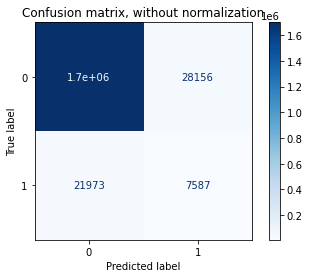

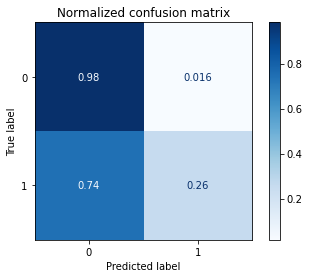

F-Score: 0.97281


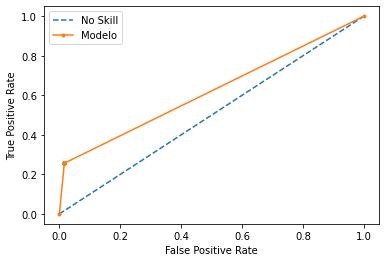

In [25]:
full_evaluation(clf_decision, x_test, y_test)

Se puede observar que el modelo, a pesar de tener una precisión muy alta sin y con threshold, no es buen modelo, ya que la proporción de falsos negativos es alta.

### GLM: Logistic Regression

In [26]:
clf_logistic = LogisticRegression()
clf_logistic.fit(x_train, y_train)
pickle.dump(clf_logistic, open('clf_logistic.sav', 'wb'))

In [20]:
clf_logistic = pickle.load(open('clf_logistic.sav', 'rb'))

Accuracy: 0.9178532080556457
Matriz de confusión
Confusion matrix, without normalization
[[1602487  126074]
 [  18350   11210]]
Normalized confusion matrix
[[0.92706419 0.07293581]
 [0.62077131 0.37922869]]


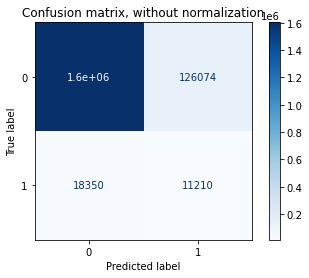

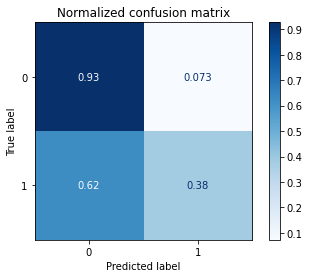

F-Score: 0.94305
Curva ROC


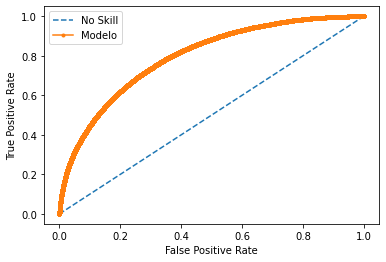

Best Threshold=0.263436, G-Mean=0.718
Curva ROC con threshold


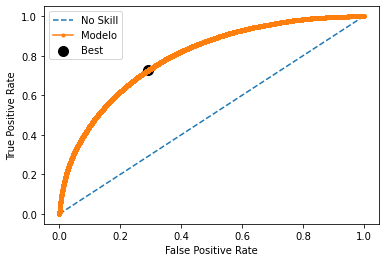

Matriz de confusión con threshold
[[1223171  505390]
 [   8022   21538]]
[[0.70762386 0.29237614]
 [0.27138024 0.72861976]]
Accuracy: 0.7079768684862987
F-Score: 0.81394
Curva recall-precision
Logistic: f1=0.077 auc=0.089


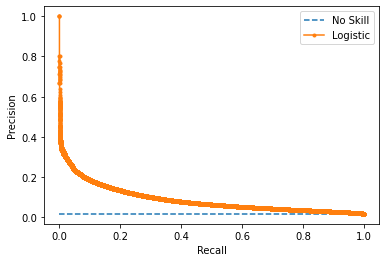

Gráfico de ganancia acumulada


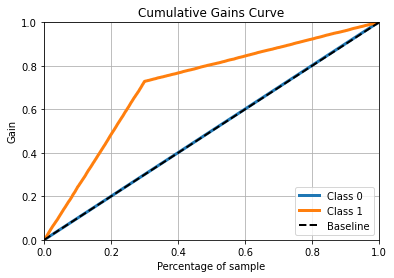

Curva lift


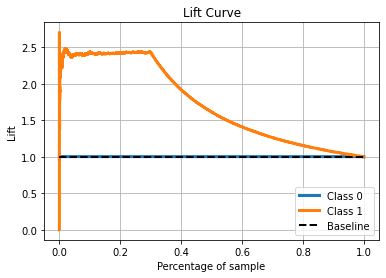

In [21]:
full_evaluation(clf_logistic, x_test, y_test, True)

Se observa que este modelo es notablemente mejor que el Decision Tree Classifier, ya que tiene una precisión del 72,5%, menor que la anterior, pero acierta más en los casos en los que hay al menos un fallecido.

Con un threshold de 0,26, los falsos negativos han descendido a un 27%, por lo que este modelo acierta más en el caso de que exista un potencial fallecimiento, objetivo principal de nuestro modelo.

### Random Forest Classifier

In [28]:
clf_forest = RandomForestClassifier()
clf_forest.fit(x_train, y_train)
pickle.dump(clf_forest, open('clf_forest.sav', 'wb'))

In [45]:
clf_forest = pickle.load(open('clf_forest.sav', 'rb'))

Accuracy: 0.9846944550460406
Matriz de confusión
Confusion matrix, without normalization
[[1726295    2266]
 [  24643    4917]]
Normalized confusion matrix
[[0.99868908 0.00131092]
 [0.83366035 0.16633965]]


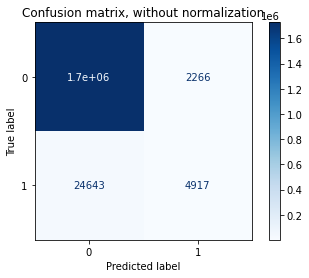

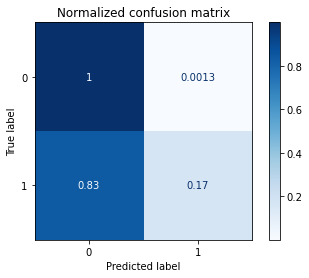

F-Score: 0.98008
Curva ROC


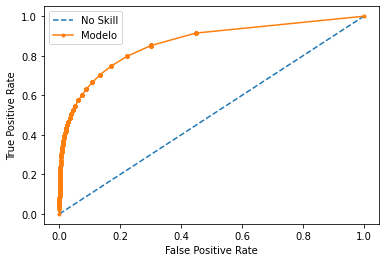

Best Threshold=0.036420, G-Mean=0.788
Curva ROC con threshold


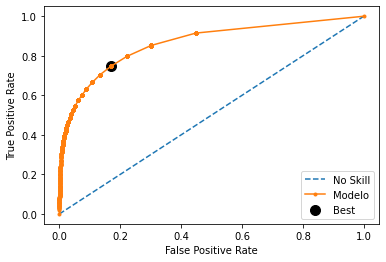

Matriz de confusión con threshold
[[1434251  294310]
 [   7451   22109]]
[[0.82973699 0.17026301]
 [0.2520636  0.7479364 ]]
Accuracy: 0.8283616429130873
F-Score: 0.89175
Curva recall-precision
Logistic: f1=0.128 auc=0.311


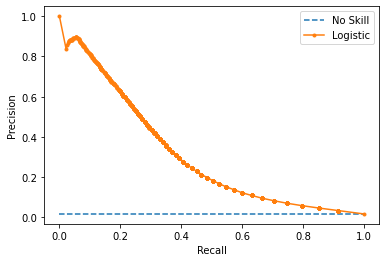

The ypred dimension is  1
The ytest dimension is  1
Gráfico de ganancia acumulada


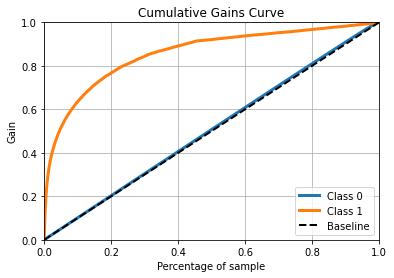

Curva lift


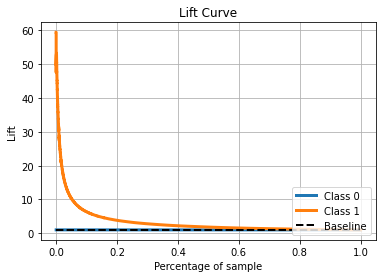

In [46]:
full_evaluation(clf_forest, x_test, y_test, True)

Random Forest es nuestro mejor modelo, con una precisión del 82,84% y un acierto del 74,79% de los casos en los que hay fallecidos.

### XGBoost

In [25]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0, n_jobs=-1)
xgb_model.fit(x_train, y_train)
pickle.dump(xgb_model, open('xgb_model.sav', 'wb'))

[08:51:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
xgb_model = pickle.load(open('xgb_model.sav', 'rb'))

Accuracy: 0.920726161623688
Matriz de confusión
Confusion matrix, without normalization
[[1605189  123372]
 [  16001   13559]]
Normalized confusion matrix
[[0.92862734 0.07137266]
 [0.54130582 0.45869418]]


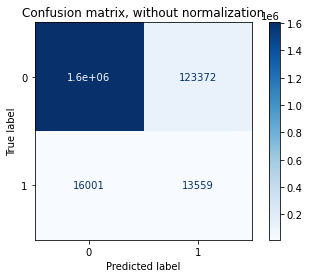

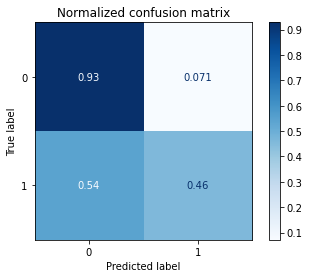

F-Score: 0.94502
Curva ROC


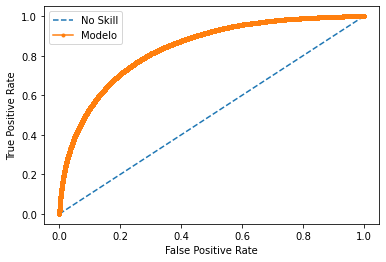

Best Threshold=0.267974, G-Mean=0.757
Curva ROC con threshold


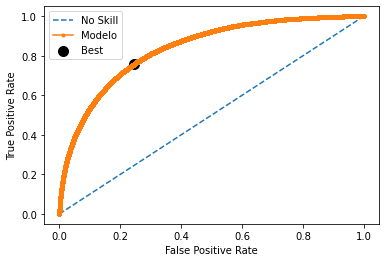

Matriz de confusión con threshold
[[1302423  426138]
 [   7106   22454]]
[[0.7534724  0.2465276 ]
 [0.24039242 0.75960758]]
Accuracy: 0.7535755502607614
F-Score: 0.84456
Curva recall-precision
Logistic: f1=0.094 auc=0.134


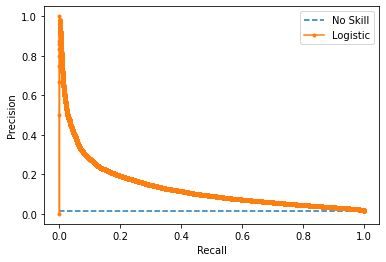

Gráfico de ganancia acumulada


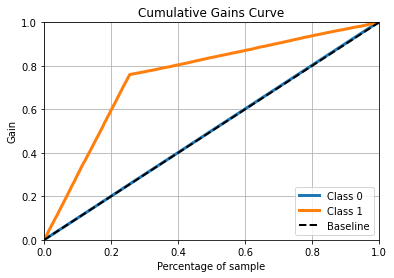

Curva lift


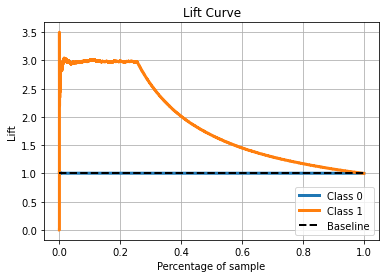

In [58]:
full_evaluation(xgb_model, x_test, y_test, True)

### Light GBM

In [27]:
clf_lgb = lgb.LGBMClassifier()
clf_lgb.fit(x_train, y_train)
pickle.dump(clf_lgb, open('clf_lgb.sav', 'wb'))

In [49]:
clf_lgb = pickle.load(open('clf_lgb.sav', 'rb'))

Accuracy: 0.9174778072726507
Matriz de confusión
Confusion matrix, without normalization
[[1599982  128579]
 [  16505   13055]]
Normalized confusion matrix
[[0.92561501 0.07438499]
 [0.55835589 0.44164411]]


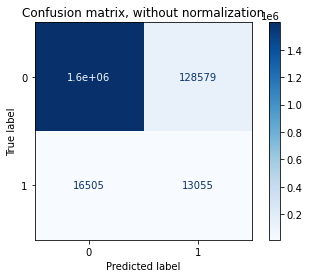

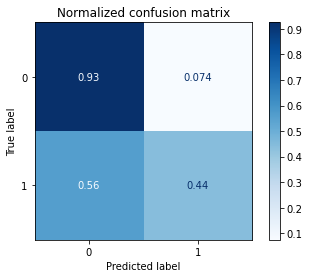

F-Score: 0.94311
Curva ROC


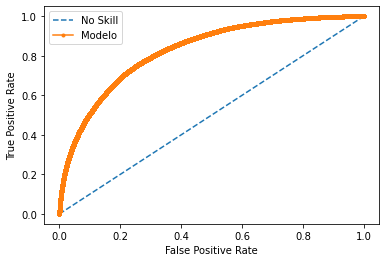

Best Threshold=0.272856, G-Mean=0.749
Curva ROC con threshold


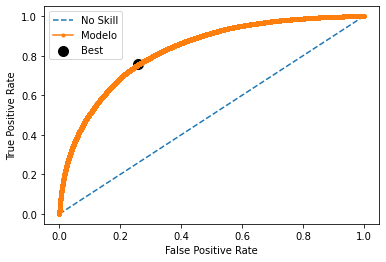

Matriz de confusión con threshold
[[1281195  447366]
 [   7210   22350]]
[[0.74119166 0.25880834]
 [0.24391069 0.75608931]]
Accuracy: 0.74144214192311
F-Score: 0.83655
Curva recall-precision
Logistic: f1=0.090 auc=0.116


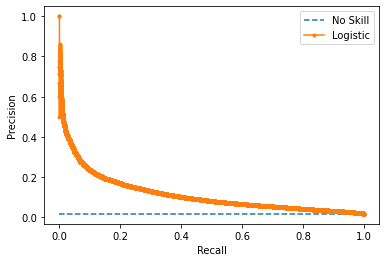

The ypred dimension is  1
The ytest dimension is  1
Gráfico de ganancia acumulada


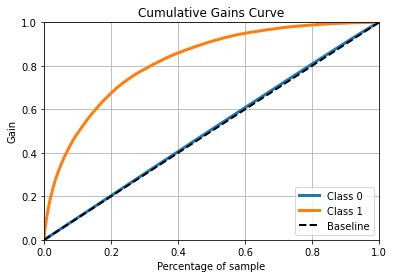

Curva lift


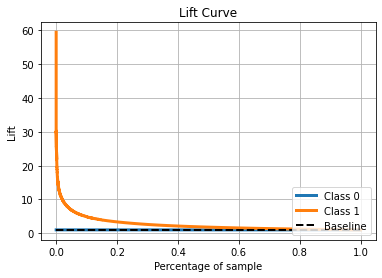

In [50]:
full_evaluation(clf_lgb, x_test, y_test, True)

### Ada Boost Classifier

In [29]:
clf_ada = AdaBoostClassifier()
clf_ada.fit(x_train, y_train)

AdaBoostClassifier()

In [30]:
pickle.dump(clf_ada, open('clf_ada.sav', 'wb'))

Accuracy: 0.9121107136539521
Confusion matrix, without normalization
[[1591728  136833]
 [  17687   11873]]
Normalized confusion matrix
[[0.92083994 0.07916006]
 [0.59834235 0.40165765]]


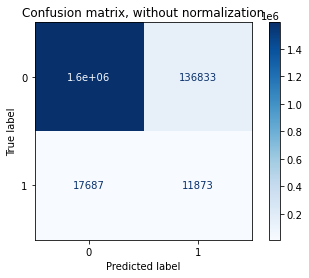

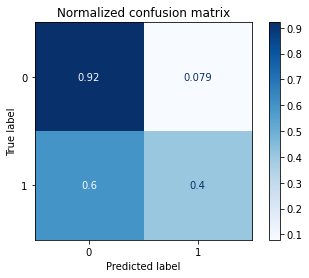

F-Score: 0.93991


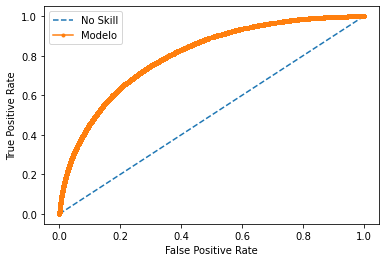

Best Threshold=0.494426, G-Mean=0.725


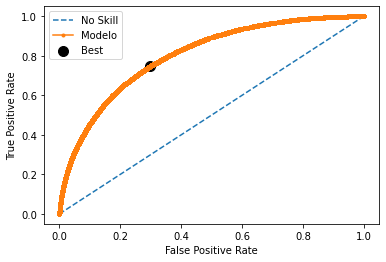

[[1212823  515738]
 [   7433   22127]]
[[0.70163737 0.29836263]
 [0.25145467 0.74854533]]
Accuracy: 0.7024260559995587
F-Score: 0.81006


In [31]:
full_evaluation(clf_ada, x_test, y_test, True)

### Gradient Boosting Classifier

In [34]:
clf_gradient = GradientBoostingClassifier()
clf_gradient.fit(x_train, y_train)

GradientBoostingClassifier()

In [35]:
pickle.dump(clf_gradient, open('clf_gradient.sav', 'wb'))

Accuracy: 0.9319620208165422
Confusion matrix, without normalization
[[1628026  100535]
 [  19084   10476]]
Normalized confusion matrix
[[0.94183891 0.05816109]
 [0.64560217 0.35439783]]


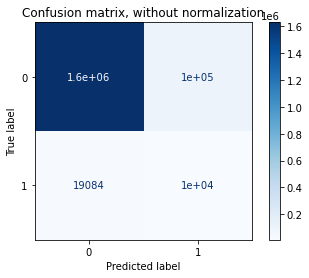

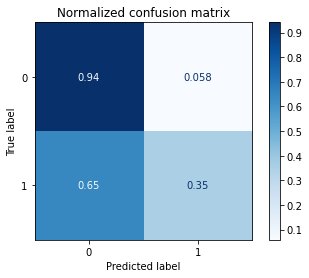

F-Score: 0.95085


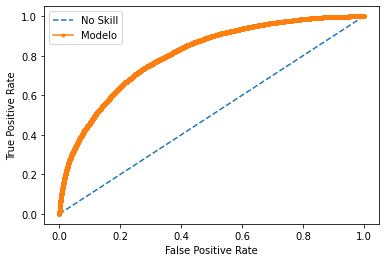

Best Threshold=0.261135, G-Mean=0.729


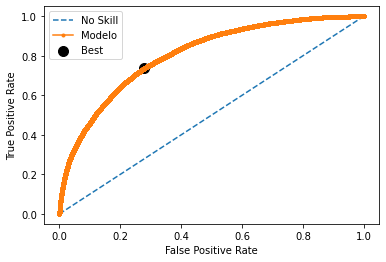

[[1246409  482152]
 [   7764   21796]]
[[0.72106741 0.27893259]
 [0.26265223 0.73734777]]
Accuracy: 0.7213411363609217
F-Score: 0.82307


In [36]:
full_evaluation(clf_gradient, x_test, y_test, True)

### Lasso & Linear Model

In [22]:
features = x_train.columns

In [23]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [24]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,5,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [25]:
search.fit(x_train,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.830 total time= 1.6min
[CV 2/5] END .................model__alpha=0.1;, score=-0.229 total time= 1.9min
[CV 3/5] END .................model__alpha=0.1;, score=-0.107 total time= 1.4min
[CV 4/5] END .................model__alpha=0.1;, score=-0.107 total time= 1.5min
[CV 5/5] END .................model__alpha=0.1;, score=-0.107 total time= 1.2min
[CV 1/5] END .................model__alpha=0.2;, score=-0.830 total time= 1.0min
[CV 2/5] END .................model__alpha=0.2;, score=-0.240 total time= 1.1min
[CV 3/5] END .................model__alpha=0.2;, score=-0.115 total time= 1.1min
[CV 4/5] END .................model__alpha=0.2;, score=-0.115 total time= 1.2min
[CV 5/5] END .................model__alpha=0.2;, score=-0.115 total time= 1.2min
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.830 total time= 1.0min
[CV 2/5] END .model__alpha=0.30000000000000004;

[CV 2/5] END .................model__alpha=2.1;, score=-0.240 total time= 1.3min
[CV 3/5] END .................model__alpha=2.1;, score=-0.115 total time= 1.2min
[CV 4/5] END .................model__alpha=2.1;, score=-0.115 total time= 1.3min
[CV 5/5] END .................model__alpha=2.1;, score=-0.115 total time= 1.3min
[CV 1/5] END .................model__alpha=2.2;, score=-0.830 total time= 1.0min
[CV 2/5] END .................model__alpha=2.2;, score=-0.240 total time= 1.0min
[CV 3/5] END .................model__alpha=2.2;, score=-0.115 total time= 1.2min
[CV 4/5] END .................model__alpha=2.2;, score=-0.115 total time= 1.2min
[CV 5/5] END .................model__alpha=2.2;, score=-0.115 total time= 1.2min
[CV 1/5] END ..model__alpha=2.3000000000000003;, score=-0.830 total time= 1.1min
[CV 2/5] END ..model__alpha=2.3000000000000003;, score=-0.240 total time= 1.2min
[CV 3/5] END ..model__alpha=2.3000000000000003;, score=-0.115 total time= 1.2min
[CV 4/5] END ..model__alpha=

[CV 4/5] END .................model__alpha=4.1;, score=-0.115 total time= 1.0min
[CV 5/5] END .................model__alpha=4.1;, score=-0.115 total time= 1.1min
[CV 1/5] END .................model__alpha=4.2;, score=-0.830 total time= 1.1min
[CV 2/5] END .................model__alpha=4.2;, score=-0.240 total time= 1.0min
[CV 3/5] END .................model__alpha=4.2;, score=-0.115 total time= 1.1min
[CV 4/5] END .................model__alpha=4.2;, score=-0.115 total time= 1.2min
[CV 5/5] END .................model__alpha=4.2;, score=-0.115 total time= 1.1min
[CV 1/5] END .................model__alpha=4.3;, score=-0.830 total time= 1.0min
[CV 2/5] END .................model__alpha=4.3;, score=-0.240 total time= 1.1min
[CV 3/5] END .................model__alpha=4.3;, score=-0.115 total time= 1.1min
[CV 4/5] END .................model__alpha=4.3;, score=-0.115 total time= 1.4min
[CV 5/5] END .................model__alpha=4.3;, score=-0.115 total time= 1.2min
[CV 1/5] END ..model__alpha=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [26]:
search.best_params_

{'model__alpha': 0.1}

In [27]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [28]:
importance = np.abs(coefficients)

Survived features:

In [29]:
np.array(features)[importance > 0]

array(['c_conf_21', 'c_conf_31'], dtype=object)

Discarded features:

In [30]:
np.array(features)[importance == 0]

array(['c_mnth_1.0', 'c_mnth_10.0', 'c_mnth_11.0', 'c_mnth_12.0',
       'c_mnth_2.0', 'c_mnth_3.0', 'c_mnth_4.0', 'c_mnth_5.0',
       'c_mnth_6.0', 'c_mnth_7.0', 'c_mnth_8.0', 'c_mnth_9.0',
       'c_mnth_UU', 'c_raln_1', 'c_raln_2', 'c_raln_3', 'c_raln_4',
       'c_raln_5', 'c_raln_6', 'c_raln_Q', 'c_raln_U', 'c_rcfg_01',
       'c_rcfg_02', 'c_rcfg_03', 'c_rcfg_04', 'c_rcfg_05', 'c_rcfg_06',
       'c_rcfg_07', 'c_rcfg_08', 'c_rcfg_09', 'c_rcfg_10', 'c_rcfg_QQ',
       'c_rcfg_UU', 'c_wday_1.0', 'c_wday_2.0', 'c_wday_3.0',
       'c_wday_4.0', 'c_wday_5.0', 'c_wday_6.0', 'c_wday_7.0', 'c_wday_U',
       'c_conf_01', 'c_conf_02', 'c_conf_03', 'c_conf_04', 'c_conf_05',
       'c_conf_06', 'c_conf_22', 'c_conf_23', 'c_conf_24', 'c_conf_25',
       'c_conf_32', 'c_conf_33', 'c_conf_34', 'c_conf_35', 'c_conf_36',
       'c_conf_41', 'c_conf_QQ', 'c_conf_UU', 'c_hour_00', 'c_hour_01',
       'c_hour_02', 'c_hour_03', 'c_hour_04', 'c_hour_05', 'c_hour_06',
       'c_hour_07', 'c_hour_08'